# Question 13.2

In this problem you, can simulate a simplified airport security system at a 
busy airport. 
Passengers arrive according to a Poisson distribution with $\lambda_1 = 5$ 
per minute (i.e., mean interarrival rate $\mu_1$ = 0.2 minutes) to the 
ID/boarding-pass check queue, where there are several servers who each have 
exponential service time with mean rate $\mu_2$ = 0.75 minutes. [Hint: model 
them as one block that has more than one resource.]  After that, the 
passengers are assigned to the shortest of the several personal-check queues, 
where they go through the personal scanner (time is uniformly distributed 
between 0.5 minutes and 1 minute). 

Use the Arena software (PC users) or Python with SimPy (PC or Mac users) 
to build a simulation of the system, and then vary the number of 
ID/boarding-pass checkers and personal-check queues to determine how many are 
needed to keep average wait times below 15 minutes.  [If you’re using SimPy, 
or if you have access to a non-student version of Arena, you can use 
$\lambda_1 = 50$ to simulate a busier airport.]

In [9]:
import random
import simpy
import matplotlib.pyplot as plt

In [20]:
class SecuritySystem:
    def __init__(self, env, num_scanners, num_servers):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.scanner = [simpy.Resource(env, 1) for _ in range(num_scanners)]

    def checkBoardingPass(self, checkRate):
        yield self.env.timeout(random.expovariate(1.0 / checkRate))

    def scanPerson(self, minScan, maxScan):
        yield self.env.timeout(random.uniform(minScan, maxScan))


class Passenger:
    def __init__(self, env, name, system, simulation, checkRate, minScan, maxScan):
        self.env = env
        self.name = name
        self.system = system
        self.simulation = simulation
        self.checkRate = checkRate
        self.minScan = minScan
        self.maxScan = maxScan
        self.action = env.process(self.run())

    def run(self):
        timeArrive = self.env.now

        with self.system.server.request() as request:
            yield request
            tIn = self.env.now
            yield self.env.process(self.system.checkBoardingPass(self.checkRate))
            tOut = self.env.now
            self.simulation.checkTime.append(tOut - tIn)

        minq = min(
            range(len(self.system.scanner)),
            key=lambda i: len(self.system.scanner[i].queue),
        )

        with self.system.scanner[minq].request() as request:
            yield request
            tIn = self.env.now
            yield self.env.process(self.system.scanPerson(self.minScan, self.maxScan))
            tOut = self.env.now
            self.simulation.scanTime.append(tOut - tIn)

        timeLeave = self.env.now
        self.simulation.sysTime.append(timeLeave - timeArrive)
        self.simulation.totThrough += 1


class Simulation:
    def __init__(
        self,
        numCheckers,
        numScanners,
        arrRate,
        checkRate,
        minScan,
        maxScan,
        runTime,
        replications,
    ):
        self.numCheckers = numCheckers
        self.numScanners = numScanners
        self.arrRate = arrRate
        self.checkRate = checkRate
        self.minScan = minScan
        self.maxScan = maxScan
        self.runTime = runTime
        self.replications = replications
        self.avgCheckTime = []
        self.avgScanTime = []
        self.avgWaitTime = []
        self.avgSystemTime = []

    def setup(self, env):
        self.totThrough = 0
        self.checkTime = []
        self.scanTime = []
        self.sysTime = []
        system = SecuritySystem(env, self.numScanners, self.numCheckers)
        i = 0
        while True:
            yield env.timeout(random.expovariate(self.arrRate))
            i += 1
            Passenger(
                env,
                f"Passenger {i}",
                system,
                self,
                self.checkRate,
                self.minScan,
                self.maxScan,
            )

    def run(self):
        for i in range(self.replications):
            random.seed(i)
            env = simpy.Environment()
            env.process(self.setup(env))
            env.run(until=self.runTime)

            self.avgSystemTime.append(sum(self.sysTime) / self.totThrough)
            self.avgCheckTime.append(sum(self.checkTime) / self.totThrough)
            self.avgScanTime.append(sum(self.scanTime) / self.totThrough)
            self.avgWaitTime.append(
                self.avgSystemTime[i] - self.avgCheckTime[i] - self.avgScanTime[i]
            )

            print(
                f"{self.totThrough} : Replication {i+1} times {self.avgSystemTime[i]:.2f} {self.avgCheckTime[i]:.2f} {self.avgScanTime[i]:.2f} {self.avgWaitTime[i]:.2f}"
            )

        print("-----")
        print(
            f"Average system time = {sum(self.avgSystemTime) / self.replications:.2f}"
        )
        print(f"Average check time = {sum(self.avgCheckTime) / self.replications:.2f}")
        print(f"Average scan time = {sum(self.avgScanTime) / self.replications:.2f}")
        print(f"Average wait time = {sum(self.avgWaitTime) / self.replications:.2f}")

    def plot_results(self):
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(self.avgSystemTime, label="Avg. System Time")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average System Time")
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.plot(self.avgCheckTime, label="Avg. Check Time")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Check Time")
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.plot(self.avgScanTime, label="Avg. Scan Time")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Scan Time")
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.plot(self.avgWaitTime, label="Avg. Wait Time")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Wait Time")
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

    def plot_histogram(self):
        plt.figure(figsize=(12, 8))

        plt.hist(self.sysTime, bins=30, alpha=0.7, label="System Time")
        plt.xlabel("Time (minutes)")
        plt.ylabel("Frequency")
        plt.title("Histogram of System Times")
        plt.legend()

        plt.show()

    def plot_boxplot(self):
        plt.figure(figsize=(12, 8))

        data = [self.checkTime, self.scanTime, self.sysTime]
        plt.boxplot(data, tick_labels=["Check Time", "Scan Time", "System Time"])
        plt.ylabel("Time (minutes)")
        plt.title("Box Plot of Times")

        plt.show()

33441 : Replication 1 times 26.74 0.75 0.75 25.24
33308 : Replication 2 times 29.38 0.75 0.75 27.87
33454 : Replication 3 times 25.86 0.75 0.75 24.36
33418 : Replication 4 times 28.76 0.75 0.75 27.26
33310 : Replication 5 times 29.46 0.75 0.75 27.96
33225 : Replication 6 times 30.90 0.76 0.75 29.40
33401 : Replication 7 times 28.18 0.75 0.75 26.68
33428 : Replication 8 times 29.98 0.75 0.75 28.48
33485 : Replication 9 times 28.39 0.75 0.75 26.89
33487 : Replication 10 times 28.82 0.75 0.75 27.32
-----
Average system time = 28.65
Average check time = 0.75
Average scan time = 0.75
Average wait time = 27.15


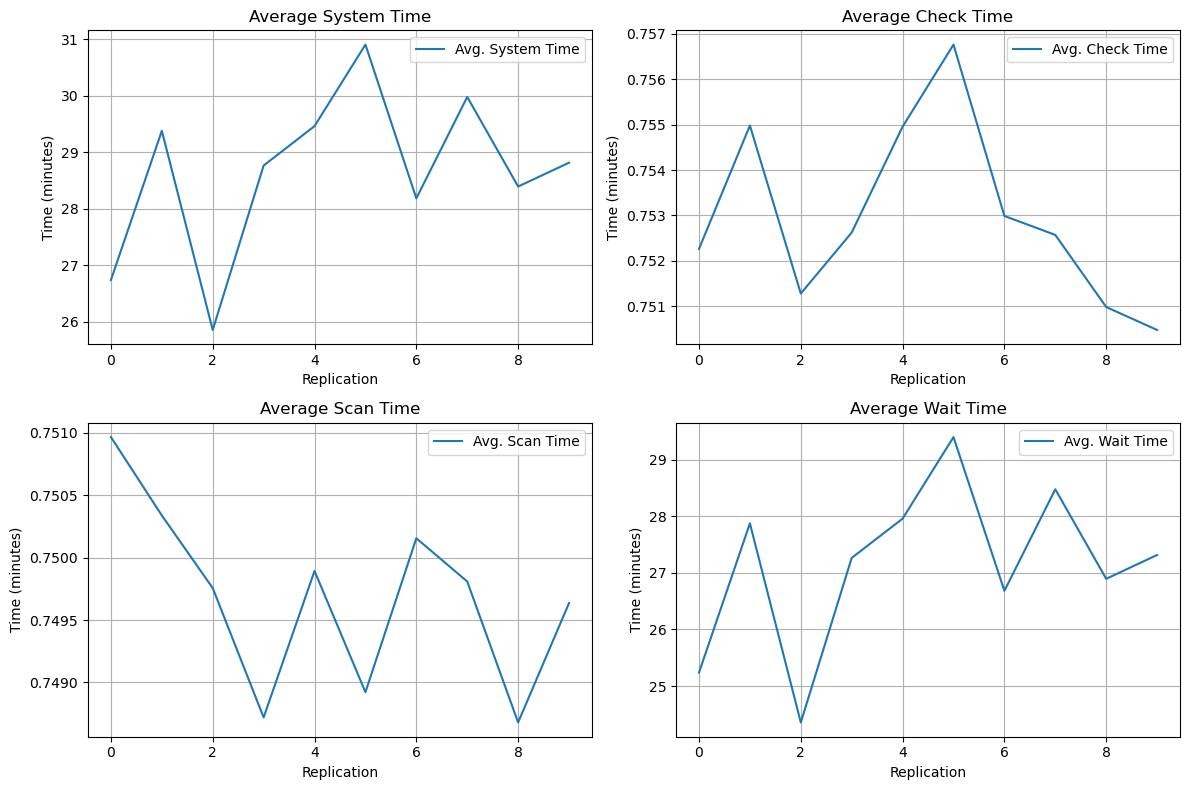

In [21]:
numCheckers = 35
numScanners = 35
arrRate = 50
checkRate = 0.75
minScan = 0.5
maxScan = 1.0
runTime = 720
replications = 10

sim = Simulation(numCheckers, numScanners, arrRate, checkRate, minScan, maxScan, runTime, replications)
sim.run()
sim.plot_results()
sim.plot_histogram()

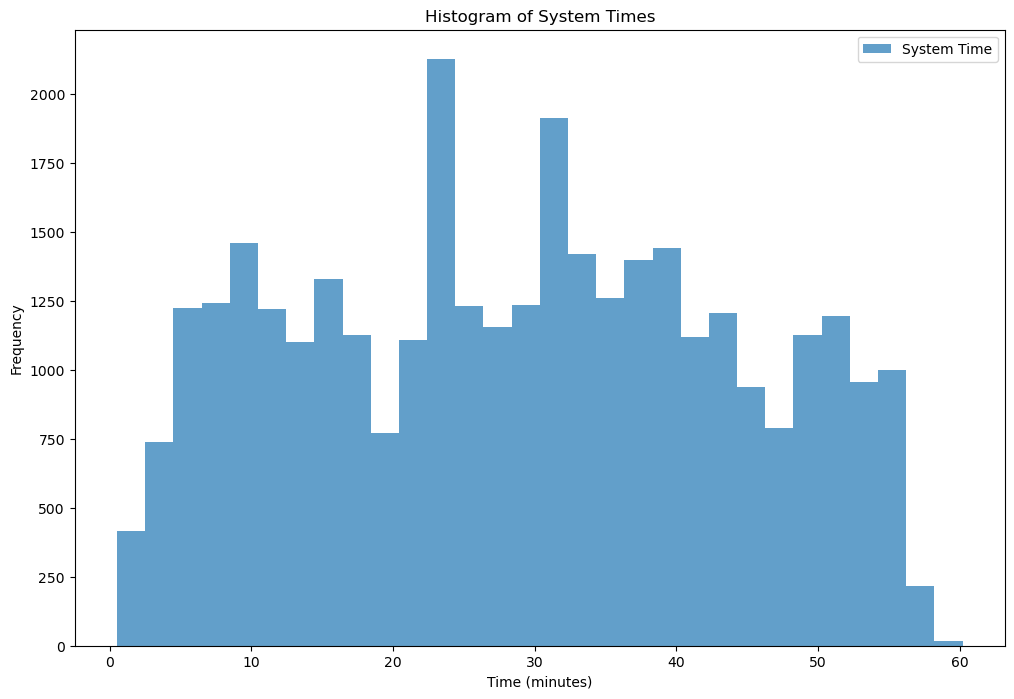

3615 : Replication 1 times 1.92 0.74 0.75 0.43
3545 : Replication 2 times 1.93 0.75 0.75 0.43
3622 : Replication 3 times 1.93 0.74 0.75 0.44
3558 : Replication 4 times 1.95 0.76 0.75 0.44
3618 : Replication 5 times 1.93 0.75 0.75 0.43
3521 : Replication 6 times 1.92 0.74 0.75 0.43
3650 : Replication 7 times 1.94 0.76 0.75 0.43
3578 : Replication 8 times 1.91 0.73 0.75 0.43
3626 : Replication 9 times 1.91 0.73 0.75 0.43
3542 : Replication 10 times 1.91 0.73 0.75 0.42
3612 : Replication 11 times 1.91 0.73 0.75 0.43
3644 : Replication 12 times 1.93 0.75 0.75 0.43
3566 : Replication 13 times 1.93 0.75 0.75 0.43
3505 : Replication 14 times 1.92 0.75 0.75 0.42
3586 : Replication 15 times 1.95 0.77 0.75 0.43
3582 : Replication 16 times 1.94 0.76 0.75 0.43
3557 : Replication 17 times 1.93 0.75 0.75 0.43
3565 : Replication 18 times 1.91 0.73 0.75 0.43
3764 : Replication 19 times 1.94 0.76 0.75 0.44
3678 : Replication 20 times 1.93 0.74 0.75 0.44
3556 : Replication 21 times 1.92 0.75 0.75 0.42
3

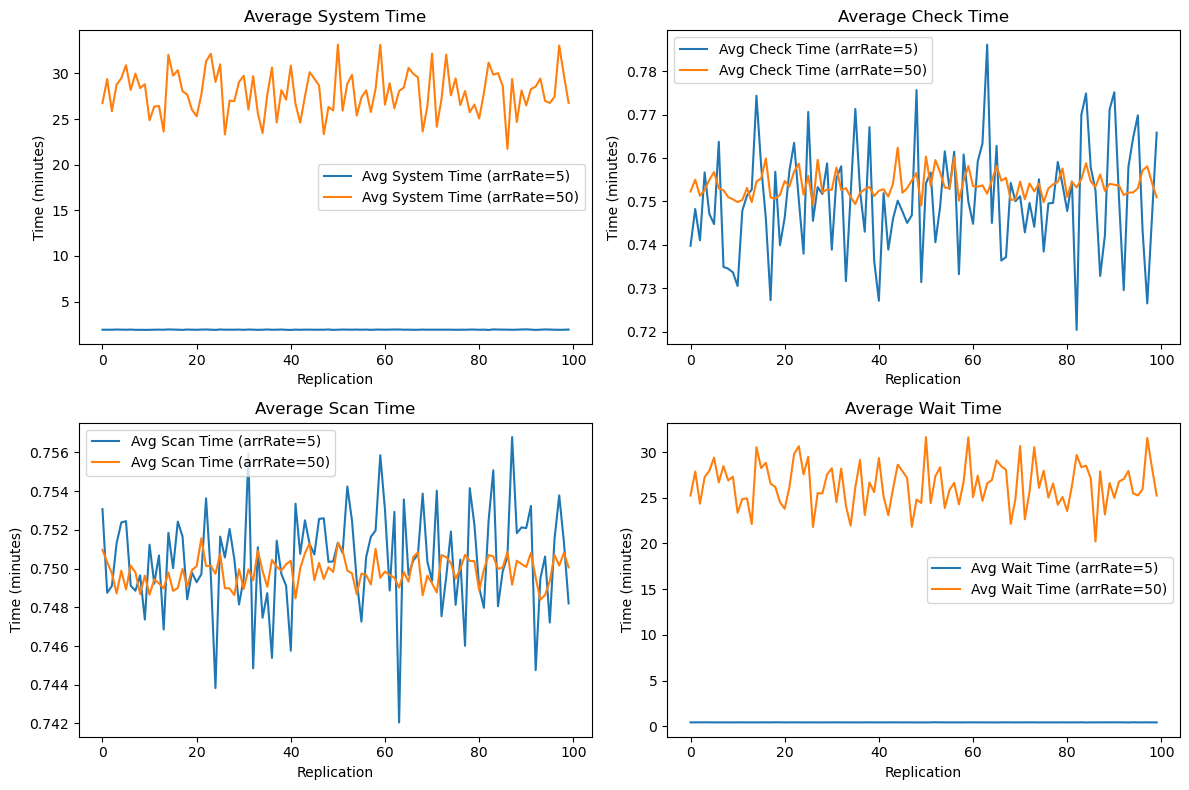

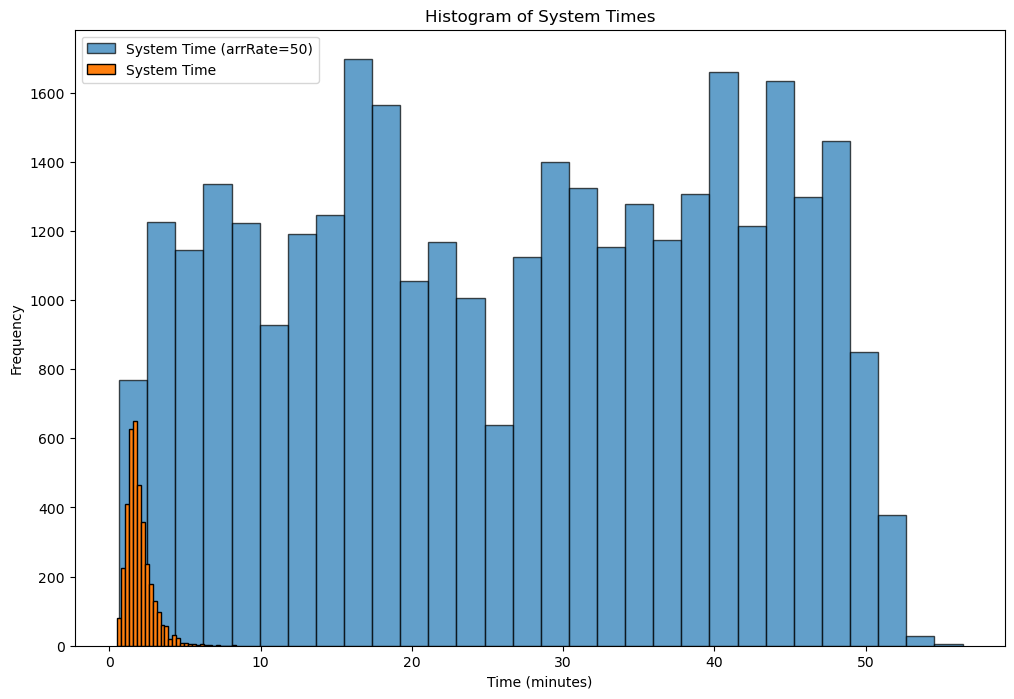

In [28]:
import simpy
import random
import matplotlib.pyplot as plt


class SecuritySystem:
    def __init__(self, env, num_scanners, num_servers):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.scanner = [simpy.Resource(env, 1) for _ in range(num_scanners)]
        self.server_busy_time = 0
        self.scanner_busy_time = [0] * num_scanners

    def checkBoardingPass(self, checkRate):
        start_time = self.env.now
        yield self.env.timeout(random.expovariate(1.0 / checkRate))
        self.server_busy_time += self.env.now - start_time

    def scanPerson(self, minScan, maxScan, scanner_index):
        start_time = self.env.now
        yield self.env.timeout(random.uniform(minScan, maxScan))
        self.scanner_busy_time[scanner_index] += self.env.now - start_time


class Passenger:
    def __init__(self, env, name, system, simulation, checkRate, minScan, maxScan):
        self.env = env
        self.name = name
        self.system = system
        self.simulation = simulation
        self.checkRate = checkRate
        self.minScan = minScan
        self.maxScan = maxScan
        self.action = env.process(self.run())

    def run(self):
        timeArrive = self.env.now

        with self.system.server.request() as request:
            yield request
            tIn = self.env.now
            yield self.env.process(self.system.checkBoardingPass(self.checkRate))
            tOut = self.env.now
            self.simulation.checkTime.append(tOut - tIn)

        minq = min(
            range(len(self.system.scanner)),
            key=lambda i: len(self.system.scanner[i].queue),
        )

        with self.system.scanner[minq].request() as request:
            yield request
            tIn = self.env.now
            yield self.env.process(
                self.system.scanPerson(self.minScan, self.maxScan, minq)
            )
            tOut = self.env.now
            self.simulation.scanTime.append(tOut - tIn)

        timeLeave = self.env.now
        self.simulation.sysTime.append(timeLeave - timeArrive)
        self.simulation.totThrough += 1


class Simulation:
    def __init__(
        self,
        numCheckers,
        numScanners,
        arrRate,
        checkRate,
        minScan,
        maxScan,
        runTime,
        replications,
    ):
        self.numCheckers = numCheckers
        self.numScanners = numScanners
        self.arrRate = arrRate
        self.checkRate = checkRate
        self.minScan = minScan
        self.maxScan = maxScan
        self.runTime = runTime
        self.replications = replications
        self.avgCheckTime = []
        self.avgScanTime = []
        self.avgWaitTime = []
        self.avgSystemTime = []
        self.server_utilization = []
        self.scanner_utilization = []

    def setup(self, env):
        self.totThrough = 0
        self.checkTime = []
        self.scanTime = []
        self.sysTime = []
        system = SecuritySystem(env, self.numScanners, self.numCheckers)
        self.system = system
        i = 0
        while True:
            yield env.timeout(random.expovariate(self.arrRate))
            i += 1
            Passenger(
                env,
                f"Passenger {i}",
                system,
                self,
                self.checkRate,
                self.minScan,
                self.maxScan,
            )

    def run(self):
        for i in range(self.replications):
            random.seed(i)
            env = simpy.Environment()
            env.process(self.setup(env))
            env.run(until=self.runTime)

            self.avgSystemTime.append(sum(self.sysTime) / self.totThrough)
            self.avgCheckTime.append(sum(self.checkTime) / self.totThrough)
            self.avgScanTime.append(sum(self.scanTime) / self.totThrough)
            self.avgWaitTime.append(
                self.avgSystemTime[i] - self.avgCheckTime[i] - self.avgScanTime[i]
            )

            self.server_utilization.append(
                self.system.server_busy_time / (self.runTime * self.numCheckers)
            )
            self.scanner_utilization.append(
                [
                    busy_time / self.runTime
                    for busy_time in self.system.scanner_busy_time
                ]
            )

            print(
                f"{self.totThrough} : Replication {i+1} times {self.avgSystemTime[i]:.2f} {self.avgCheckTime[i]:.2f} {self.avgScanTime[i]:.2f} {self.avgWaitTime[i]:.2f}"
            )

        print("-----")
        print(
            f"Average system time = {sum(self.avgSystemTime) / self.replications:.2f}"
        )
        print(f"Average check time = {sum(self.avgCheckTime) / self.replications:.2f}")
        print(f"Average scan time = {sum(self.avgScanTime) / self.replications:.2f}")
        print(f"Average wait time = {sum(self.avgWaitTime) / self.replications:.2f}")

    def plot_results(self, other_simulation=None):
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(self.avgSystemTime, label="Avg System Time (arrRate=5)")
        if other_simulation:
            plt.plot(
                other_simulation.avgSystemTime, label="Avg System Time (arrRate=50)"
            )
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average System Time")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(self.avgCheckTime, label="Avg Check Time (arrRate=5)")
        if other_simulation:
            plt.plot(other_simulation.avgCheckTime, label="Avg Check Time (arrRate=50)")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Check Time")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(self.avgScanTime, label="Avg Scan Time (arrRate=5)")
        if other_simulation:
            plt.plot(other_simulation.avgScanTime, label="Avg Scan Time (arrRate=50)")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Scan Time")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(self.avgWaitTime, label="Avg Wait Time (arrRate=5)")
        if other_simulation:
            plt.plot(other_simulation.avgWaitTime, label="Avg Wait Time (arrRate=50)")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Wait Time")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_results2(self):
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(self.avgSystemTime, label="Avg System Time")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average System Time")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(self.avgCheckTime, label="Avg Check Time")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Check Time")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(self.avgScanTime, label="Avg Scan Time")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Scan Time")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(self.avgWaitTime, label="Avg Wait Time")
        plt.xlabel("Replication")
        plt.ylabel("Time (minutes)")
        plt.title("Average Wait Time")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_histogram(self, other_sysTime=None, other_label=None):
        plt.figure(figsize=(12, 8))

        # Create a histogram of system times with borders around the bins
        # plt.hist(
        #     self.sysTime, bins=30, alpha=0.7, edgecolor="black", label="System Time"
        # )

        if other_sysTime is not None and other_label is not None:
            plt.hist(
                other_sysTime, bins=30, alpha=0.7, edgecolor="black", label=other_label
            )

        plt.hist(
            self.sysTime, bins=30, alpha=1.0, edgecolor="black", label="System Time"
        )

        plt.xlabel("Time (minutes)")
        plt.ylabel("Frequency")
        plt.title("Histogram of System Times")
        plt.legend()

        plt.show()


if __name__ == "__main__":
    # Example usage
    numCheckers = 35
    numScanners = 35
    checkRate = 0.75
    minScan = 0.5
    maxScan = 1.0
    runTime = 720
    replications = 100

    # Simulation with arrRate = 5
    sim1 = Simulation(
        numCheckers, numScanners, 5, checkRate, minScan, maxScan, runTime, replications
    )
    sim1.run()

    # Simulation with arrRate = 50
    sim2 = Simulation(
        numCheckers, numScanners, 50, checkRate, minScan, maxScan, runTime, replications
    )
    sim2.run()

    # Plot combined results for both simulations
    sim1.plot_results(other_simulation=sim2)
    
    # Plot histograms for both simulations
    sim1.plot_histogram(
        other_sysTime=sim2.sysTime, other_label="System Time (arrRate=50)"
    )

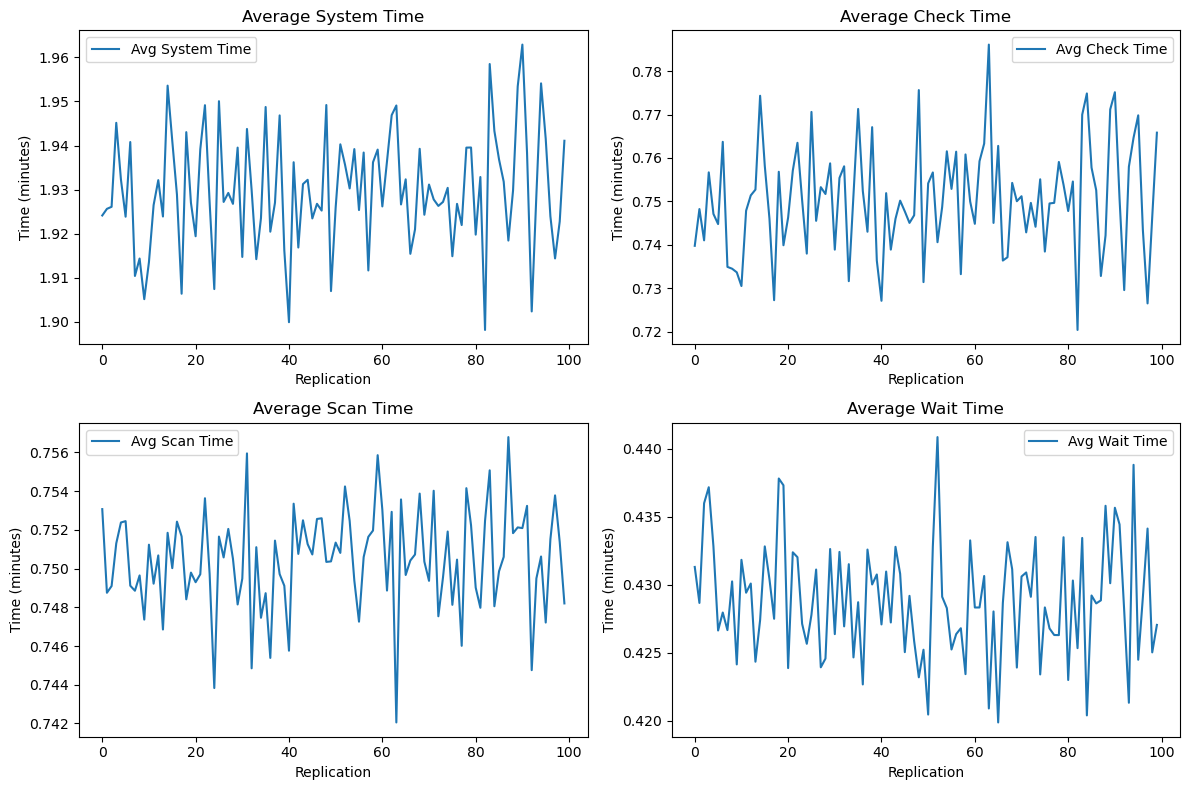

In [29]:
sim1.plot_results2()

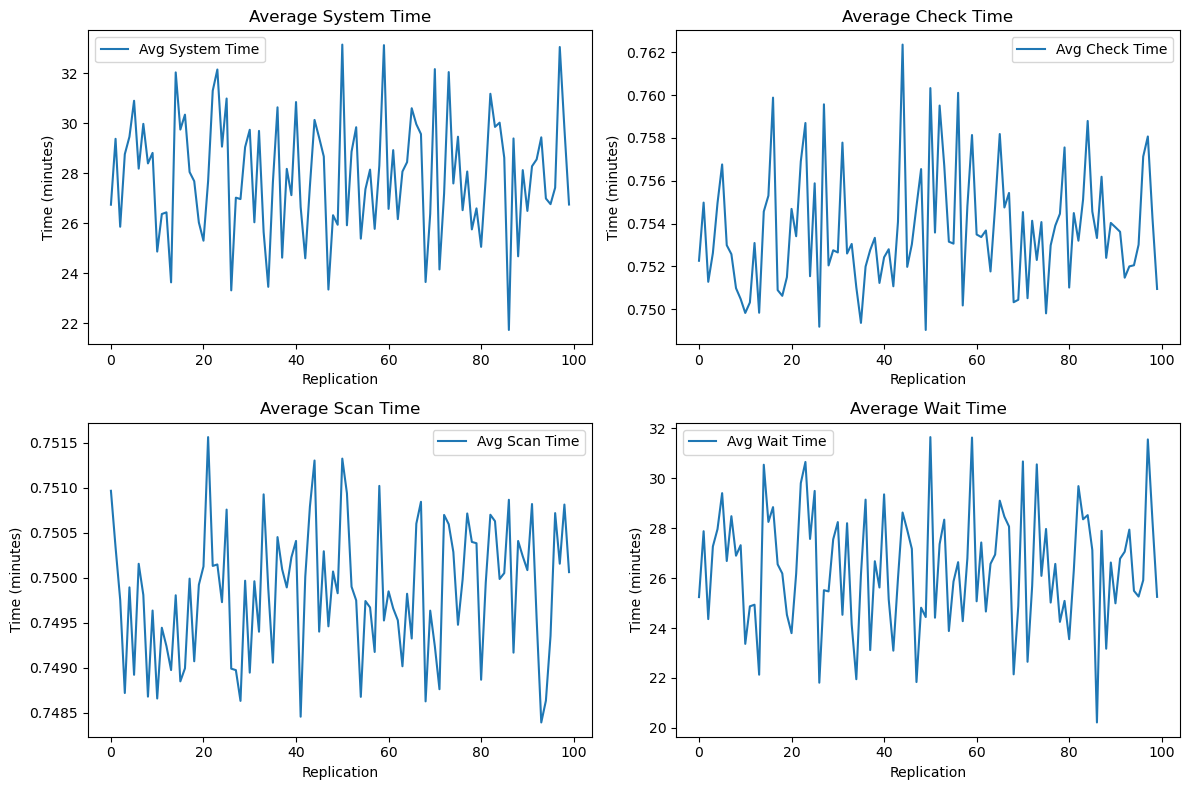

In [30]:
sim2.plot_results2()

VARY TO GET BELOW 15 MIN WAIT TIME 

MORE FOR BUSIER AIRPORT

LESS FOR SMALLER AIRPORT